In [2]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

from sklearn.datasets import make_classification, make_blobs, make_spd_matrix
from scipy.spatial.distance import pdist, squareform

Populating the interactive namespace from numpy and matplotlib


In [3]:
[X, Y] = make_blobs(1500, 10, 3, shuffle = False)

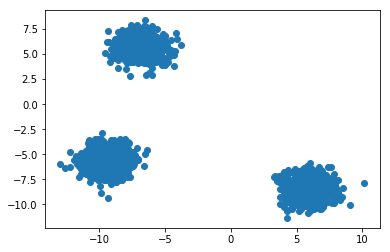

In [4]:
plt.scatter(X[:,0], X[:,1])
plt.show()

## Data

* [Pytorch Transform Documentation](http://pytorch.org/docs/torchvision/transforms.html)


1. **torchvision.transforms.Compose:** 여러개의 tranforms을 실행합니다. 
2. **torchvision.transforms.ToTensor:** PIL.Image 또는 [0, 255] range의 Numpy array(H x W x C)를 (C x H x W)의 **[0.0, 1.0] range**를 갖은 torch.FloatTensor로 변형시킵니다. <br>여기서 포인트가 0에서 1사이의 값을 갖은 값으로 normalization이 포함되있습니다. 
3. **dataloader.DataLoader:** 사용하여 training시킬때 1개의 batch를 가져올때 shape이 **torch.Size([64, 1, 28, 28])** 이렇게 나옵니다. 

In [5]:
data = torch.from_numpy(X)

categories = torch.from_numpy(Y)

# Create DataLoader
#dataloader_args = dict(shuffle=True, batch_size=1,num_workers=1, pin_memory=True)
#train_loader = dataloader.DataLoader(train, **dataloader_args)
#test_loader = dataloader.DataLoader(test, **dataloader_args)

In [123]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

NameError: name 'train' is not defined

## Model

In [39]:
class Model(nn.Module):
    def __init__(self, n_inputs, n_neurons, Wx_in, Wy_in, Y_hat_in, Wx_learning_rate, Wy_learning_rate):
        super(Model, self).__init__()
        
        self.Wx = Wx_in.float() # n_neurons x n_input
        self.Wy = Wy_in.float() # n_neurons X n_neurons
        self.Y_hat = Y_hat_in.float() # n_neurons x 1
        
        self.Y0 = torch.randn(n_neurons, 1).float() # n_neurons x 1
        
        self.eta = 0.1 # learning rate
        self.eta_Wx = Wx_learning_rate
        self.eta_Wy = Wy_learning_rate
        self.ceiling = 100 # maximum activity
        self.input_size = n_inputs
        self.neuron_size = n_neurons
        self.error_Wx = 10**5
        self.error_Wy = 10**5
    
    def forward(self, X1):
#        self.Y0 = torch.ReLU(torch.mm(X0, self.Wx) + self.b) # batch_size X n_neurons
        X1 = X1.float()
        self.Y0 = torch.mm(self.Wx, X1) - torch.mm(self.Wy, self.Y0) # batch_size X n_neurons, highest activity 100
        self.Y0[self.Y0 < 0] = 0
        return self.Y0
    
    def updateY(self, Y_in):
        Y_in = Y_in.float()
        self.Y0 = self.Y0 + self.eta*(Y_in - self.Y0)

    def updateY_hat(self, outputs):
        outputs = outputs.float()
        self.Y_hat += torch.mul(outputs, outputs)
#        self.Y_hat = torch.clamp(self.Y0, -10**10, 10**10)
        self.Y_hat[torch.isnan(self.Y_hat)] = 0
        
    def updateWy(self, outputs):
        outputs = outputs.float()
        D = torch.diag(torch.diag(self.Wy))
        change_Wy = torch.div(torch.mm(outputs, outputs.T) - torch.mul(self.Wy, torch.mm(torch.mul(outputs, outputs), torch.ones((1, self.neuron_size)))), torch.mm(self.Y_hat, torch.ones((1, self.neuron_size))) + 10**-30)
        mag_change = torch.sqrt(torch.mul(change_Wy, change_Wy).mean())
#        if mag_change < self.error_Wy:
#            self.eta_Wy += 0.001
#            self.error_Wy = mag_change
#        if mag_change > self.error_Wy + 10**-5:
#            self.eta_Wy -= 0.01
#            self.error_Wy = mag_change
#        if self.eta_Wy <= 0:
#            self.eta_Wy = 10**-2
        self.Wy += self.eta_Wy*change_Wy
#        self.Wy += self.eta*torch.mul(torch.mm(outputs.T, outputs) - self.Wy, torch.mm(torch.ones((self.neuron_size, 1)), torch.mul(outputs, outputs)))
        self.Wy = self.Wy - torch.diag(torch.diag(self.Wy)) + D
        self.Wy[torch.isnan(self.Wy)] = 10
#        self.Wy = torch.clamp(self.Wy, -10**10, 10**10)

    def updateWx(self, outputs, inputs):
        inputs = inputs.float()
        outputs = outputs.float()
        change_Wx = torch.div(torch.mm(outputs, inputs.T) - torch.mul(self.Wx, torch.mm(torch.mul(outputs, outputs), torch.ones((1, self.input_size)))), torch.mm(self.Y_hat, torch.ones((1, self.input_size))) + 10**-30)
        mag_change = torch.sqrt(torch.mul(change_Wx, change_Wx).mean())
#        if mag_change < self.error_Wx:
#            self.eta_Wx += 0.001
#            self.error_Wx = mag_change
#        if mag_change > self.error_Wx + 10**-5:
#            self.eta_Wx -= 0.01
#            self.error_Wx = mag_change
#        if self.eta_Wx <= 0:
#            self.eta_Wx = 10**-2
        self.Wx += self.eta_Wx*change_Wx
#        self.Wx += self.eta*torch.mul(torch.mm(inputs.T, outputs) - self.Wx, torch.mm(torch.ones((self.input_size, 1)), torch.mul(outputs, outputs)))
        self.Wx[torch.isnan(self.Wx)] = 10
#        self.Wx = torch.clamp(self.Wx, -10**10, 10**10)

N_INPUT = 10 # number of features in input
N_NEURONS = 20 # number of units in layer
Wx_learning_rate_1 = 10**-3
Wy_learning_rate_1 = 10**-3

N_INPUT_2 = 20 # number of features in input
N_NEURONS_2 = 3 # number of units in layer
Wx_learning_rate_2 = 10**-3
Wy_learning_rate_2 = 10**-3

#model = Model(N_INPUT, N_NEURONS, torch.randn(N_NEURONS, N_INPUT), torch.from_numpy(make_spd_matrix(N_NEURONS)).float() + 5*torch.diag(torch.ones(N_NEURONS)), torch.randn(N_NEURONS, 1), W_learning_rate_1)
#model_2 = Model(N_INPUT_2, N_NEURONS_2, torch.randn(N_NEURONS_2, N_INPUT_2), torch.from_numpy(make_spd_matrix(N_NEURONS_2)).float() + 5*torch.diag(torch.ones(N_NEURONS_2)), torch.randn(N_NEURONS_2, 1), W_learning_rate_2)
model = Model(N_INPUT, N_NEURONS, torch.randn(N_NEURONS, N_INPUT), 1*torch.ones(N_NEURONS, N_NEURONS) - 1*torch.diag(torch.ones(N_NEURONS)), torch.randn(N_NEURONS, 1), Wx_learning_rate_1, Wy_learning_rate_1)
model_2 = Model(N_INPUT_2, N_NEURONS_2, torch.randn(N_NEURONS_2, N_INPUT_2), 1*torch.ones(N_NEURONS_2, N_NEURONS_2) - 1*torch.diag(torch.ones(N_NEURONS_2)), torch.randn(N_NEURONS_2, 1), Wx_learning_rate_2, Wy_learning_rate_2)
criterion = torch.nn.MSELoss()
criterion_check = torch.nn.MSELoss()
model.cuda() # CUDA!
model_2.cuda() # CUDA!
#optimizer = optim.Adam(model.parameters(), lr=0.001)

Model()

In [111]:
i = 0

tensor(0.)


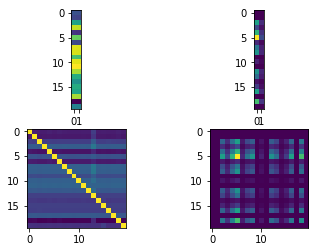

tensor(0.)


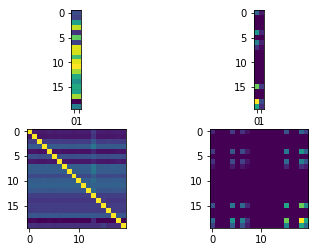

tensor(0.)


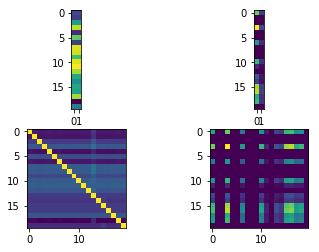

tensor(0.)


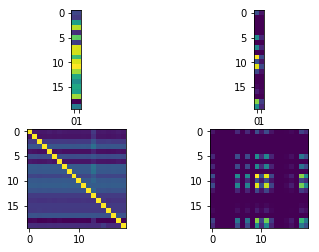

tensor(0.)


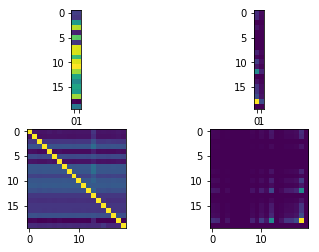

tensor(0.)


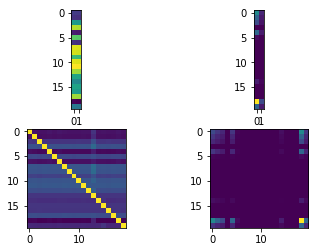

tensor(0.)


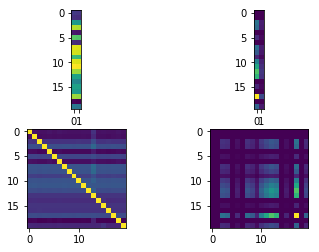

tensor(0.)


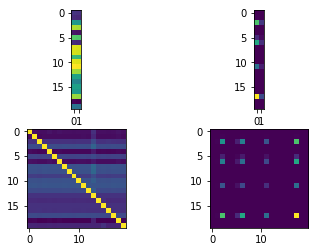

tensor(0.)


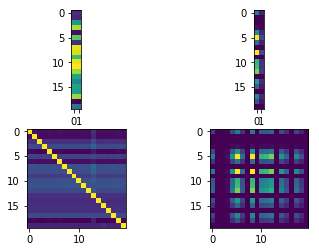

tensor(0.)


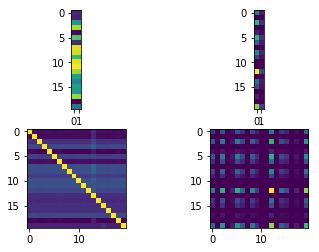

In [114]:
for k in range(100):
    inputs = data[i]
    labels = categories[i]
        # get the inputs; data is a list of [inputs, labels]
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, W_learning_rate_1)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, W_learning_rate_2)

    # forward + backward + optimize
    outputs = model.forward(inputs.flatten().view(-1, 2).T)
    loss = criterion(outputs, model.Y0)
    model.updateY(outputs)
        
    j = 0
    while(loss > 10**-5 and j < 10**5):
        outputs = model.forward(inputs.flatten().view(-1, 2).T)
        loss = criterion(outputs, model.Y0)
        model.updateY(outputs)
        j += 1
#        print(i, "loss:", loss)
        
    model.updateY_hat(outputs)
    model.updateWx(outputs, inputs.view(-1, 2).T)
    model.updateWy(outputs)       
    if k % 10 == 9:
        print(criterion(outputs, model.Y0))
        f, axarr = plt.subplots(2,2)
        axarr[0, 0].imshow(model.Wx)
        axarr[0, 1].imshow(torch.mm(outputs, inputs.float().view(2, 1).T))
        axarr[1, 0].imshow(model.Wy)
        axarr[1, 1].imshow(torch.mm(outputs, outputs.T))
        plt.show()

tensor(0.)


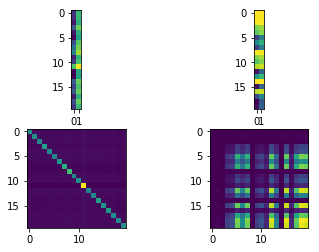

In [52]:
print(criterion(outputs, model.Y0))
f, axarr = plt.subplots(2,2)
axarr[0, 0].imshow(model.Wx)
axarr[0, 1].imshow(torch.mm(outputs, inputs.float().view(2, 1).T))
axarr[1, 0].imshow(model.Wy)
axarr[1, 1].imshow(torch.mm(outputs, outputs.T))

In [58]:
Wx_learning_rate_1 = 10**-4
Wy_learning_rate_1 = 10**-4

Wx_learning_rate_2 = 10**-4
Wy_learning_rate_2 = 10**-4

In [67]:
model.train()
output_compare = torch.ones(3, 3)

losses = []
for epoch in range(2000):
    for i in range(1500):
        inputs = data[i]
        labels = categories[i]
        # get the inputs; data is a list of [inputs, labels]
        model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, model.eta_Wx, model.eta_Wy)
        model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, model_2.eta_Wx, model_2.eta_Wy)

        # forward + backward + optimize
        outputs = model.forward(inputs.flatten().view(-1, 10).T)
        loss = criterion(outputs, model.Y0)
        model.updateY(outputs)
        
        j = 0
        while(loss > 10**-5 and j < 10**5):
            outputs = model.forward(inputs.flatten().view(-1, 10).T)
            loss = criterion(outputs, model.Y0)
            model.updateY(outputs)
            j += 1
#        print(i, "loss:", loss)
        
        model.updateY_hat(outputs)
        model.updateWx(outputs, inputs.view(-1, 10).T)
        model.updateWy(outputs)        

        # forward + backward + optimize
        outputs_2 = model_2.forward(outputs)
        loss_2 = criterion(outputs_2, model_2.Y0)
        model_2.updateY(outputs_2)
        
        j = 0
        while(loss_2 > 10**-5 and j < 10**5):
            outputs_2 = model_2.forward(outputs)
            loss_2 = criterion(outputs_2, model_2.Y0)
            model_2.updateY(outputs_2)
            j += 1
#        print(i, "loss:", loss)
        
        model_2.updateY_hat(outputs_2)
        model_2.updateWx(outputs_2, outputs)
        model_2.updateWy(outputs_2)        
        
        loss_check = criterion_check(outputs_2.T[0], output_compare[labels])
        losses.append(loss_check)
        output_compare[labels] = outputs_2.T
                
        # Display
        if i % 100 == 99:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                i , 
                1500,
                100. * i / 1500, 
                loss_check), 
                end='')
            
    print()

 Train Epoch: 0 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 1 [1499/1500 (100%)]	Loss: 51.824287
 Train Epoch: 2 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 3 [1499/1500 (100%)]	Loss: 91.970566
 Train Epoch: 4 [1499/1500 (100%)]	Loss: 63.153923
 Train Epoch: 5 [1499/1500 (100%)]	Loss: 24.040033
 Train Epoch: 6 [1499/1500 (100%)]	Loss: 13.931866
 Train Epoch: 7 [1499/1500 (100%)]	Loss: 24.445923
 Train Epoch: 8 [1499/1500 (100%)]	Loss: 1.045418
 Train Epoch: 9 [1499/1500 (100%)]	Loss: 0.616076
 Train Epoch: 10 [1499/1500 (100%)]	Loss: 8.114305
 Train Epoch: 11 [1499/1500 (100%)]	Loss: 1.131533
 Train Epoch: 12 [1499/1500 (100%)]	Loss: 20.011078
 Train Epoch: 13 [1499/1500 (100%)]	Loss: 10.259510
 Train Epoch: 14 [1499/1500 (100%)]	Loss: 0.0366892
 Train Epoch: 15 [1499/1500 (100%)]	Loss: 2.6511559
 Train Epoch: 16 [1499/1500 (100%)]	Loss: 18.911625
 Train Epoch: 17 [1499/1500 (100%)]	Loss: 54.469063
 Train Epoch: 18 [1499/1500 (100%)]	Loss: 21.257318
 Train Epoch: 19 [1499/1500 

 Train Epoch: 157 [1499/1500 (100%)]	Loss: 0.253409
 Train Epoch: 158 [1499/1500 (100%)]	Loss: 52.294411
 Train Epoch: 159 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 160 [1499/1500 (100%)]	Loss: 75.701561
 Train Epoch: 161 [1499/1500 (100%)]	Loss: 11.120940
 Train Epoch: 162 [1499/1500 (100%)]	Loss: 0.712900
 Train Epoch: 163 [1499/1500 (100%)]	Loss: 9.369690
 Train Epoch: 164 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 165 [1499/1500 (100%)]	Loss: 129.976807
 Train Epoch: 166 [1499/1500 (100%)]	Loss: 2.236618
 Train Epoch: 167 [1499/1500 (100%)]	Loss: 1.4549561
 Train Epoch: 168 [1499/1500 (100%)]	Loss: 101.341721
 Train Epoch: 169 [1499/1500 (100%)]	Loss: 256.230774
 Train Epoch: 170 [1499/1500 (100%)]	Loss: 11.163667
 Train Epoch: 171 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 172 [1499/1500 (100%)]	Loss: 42.106956
 Train Epoch: 173 [1499/1500 (100%)]	Loss: 4.411512
 Train Epoch: 174 [1499/1500 (100%)]	Loss: 0.054568
 Train Epoch: 175 [1499/1500 (100%)]	Loss: 240.50791

 Train Epoch: 312 [1499/1500 (100%)]	Loss: 88.302055
 Train Epoch: 313 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 314 [1499/1500 (100%)]	Loss: 1.444155
 Train Epoch: 315 [1499/1500 (100%)]	Loss: 421.728516
 Train Epoch: 316 [1499/1500 (100%)]	Loss: 28.858040
 Train Epoch: 317 [1499/1500 (100%)]	Loss: 4.6210644
 Train Epoch: 318 [1499/1500 (100%)]	Loss: 1.010749
 Train Epoch: 319 [1499/1500 (100%)]	Loss: 2.422061
 Train Epoch: 320 [1499/1500 (100%)]	Loss: 10.664989
 Train Epoch: 321 [1499/1500 (100%)]	Loss: 65.654343
 Train Epoch: 322 [1499/1500 (100%)]	Loss: 0.0344623
 Train Epoch: 323 [1499/1500 (100%)]	Loss: 0.106226
 Train Epoch: 324 [1499/1500 (100%)]	Loss: 0.019019
 Train Epoch: 325 [1499/1500 (100%)]	Loss: 14.958068
 Train Epoch: 326 [1499/1500 (100%)]	Loss: 24.529249
 Train Epoch: 327 [1499/1500 (100%)]	Loss: 6.755331
 Train Epoch: 328 [1499/1500 (100%)]	Loss: 8.887293
 Train Epoch: 329 [1499/1500 (100%)]	Loss: 13.110435
 Train Epoch: 330 [1499/1500 (100%)]	Loss: 0.000000
 

 Train Epoch: 467 [1499/1500 (100%)]	Loss: 0.1874636
 Train Epoch: 468 [1499/1500 (100%)]	Loss: 0.051481
 Train Epoch: 469 [1499/1500 (100%)]	Loss: 0.0000005
 Train Epoch: 470 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 471 [1499/1500 (100%)]	Loss: 4.2558169
 Train Epoch: 472 [1499/1500 (100%)]	Loss: 9.586703
 Train Epoch: 473 [1499/1500 (100%)]	Loss: 7.9939763
 Train Epoch: 474 [1499/1500 (100%)]	Loss: 15.652334
 Train Epoch: 475 [1499/1500 (100%)]	Loss: 13.232755
 Train Epoch: 476 [1499/1500 (100%)]	Loss: 55.712372
 Train Epoch: 477 [1499/1500 (100%)]	Loss: 0.113362
 Train Epoch: 478 [1499/1500 (100%)]	Loss: 8.9084276
 Train Epoch: 479 [1499/1500 (100%)]	Loss: 0.347772
 Train Epoch: 480 [1499/1500 (100%)]	Loss: 9.231121
 Train Epoch: 481 [1499/1500 (100%)]	Loss: 0.0911496
 Train Epoch: 482 [1499/1500 (100%)]	Loss: 79.970833
 Train Epoch: 483 [1499/1500 (100%)]	Loss: 0.0596943
 Train Epoch: 484 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 485 [1499/1500 (100%)]	Loss: 9.240488
 

 Train Epoch: 622 [1499/1500 (100%)]	Loss: 15.136152
 Train Epoch: 623 [1499/1500 (100%)]	Loss: 4.4880523
 Train Epoch: 624 [1499/1500 (100%)]	Loss: 0.647783
 Train Epoch: 625 [1499/1500 (100%)]	Loss: 289.746399
 Train Epoch: 626 [1499/1500 (100%)]	Loss: 0.277393
 Train Epoch: 627 [1499/1500 (100%)]	Loss: 0.831746
 Train Epoch: 628 [1499/1500 (100%)]	Loss: 2.988683
 Train Epoch: 629 [1499/1500 (100%)]	Loss: 0.624134
 Train Epoch: 630 [1499/1500 (100%)]	Loss: 103.172050
 Train Epoch: 631 [1499/1500 (100%)]	Loss: 3.355211
 Train Epoch: 632 [1499/1500 (100%)]	Loss: 3.705791
 Train Epoch: 633 [1499/1500 (100%)]	Loss: 16.684015
 Train Epoch: 634 [1499/1500 (100%)]	Loss: 2.8096276
 Train Epoch: 635 [1499/1500 (100%)]	Loss: 16.078171
 Train Epoch: 636 [1499/1500 (100%)]	Loss: 0.0000004
 Train Epoch: 637 [1499/1500 (100%)]	Loss: 1.324401
 Train Epoch: 638 [1499/1500 (100%)]	Loss: 213.388504
 Train Epoch: 639 [1499/1500 (100%)]	Loss: 18.668468
 Train Epoch: 640 [1499/1500 (100%)]	Loss: 0.000000

 Train Epoch: 777 [1499/1500 (100%)]	Loss: 160.563477
 Train Epoch: 778 [1499/1500 (100%)]	Loss: 1.5233428
 Train Epoch: 779 [1499/1500 (100%)]	Loss: 0.758141
 Train Epoch: 780 [1499/1500 (100%)]	Loss: 0.028052
 Train Epoch: 781 [1499/1500 (100%)]	Loss: 0.225908
 Train Epoch: 782 [1499/1500 (100%)]	Loss: 58.550388
 Train Epoch: 783 [1499/1500 (100%)]	Loss: 3.9178549
 Train Epoch: 784 [1499/1500 (100%)]	Loss: 9.0999800
 Train Epoch: 785 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 786 [1499/1500 (100%)]	Loss: 45.220791
 Train Epoch: 787 [1499/1500 (100%)]	Loss: 1.992477
 Train Epoch: 788 [1499/1500 (100%)]	Loss: 5.6806851
 Train Epoch: 789 [1499/1500 (100%)]	Loss: 81.833336
 Train Epoch: 790 [1499/1500 (100%)]	Loss: 1.054837
 Train Epoch: 791 [1499/1500 (100%)]	Loss: 7.306122
 Train Epoch: 792 [1499/1500 (100%)]	Loss: 126.847885
 Train Epoch: 793 [1499/1500 (100%)]	Loss: 0.043428
 Train Epoch: 794 [1499/1500 (100%)]	Loss: 0.1341625
 Train Epoch: 795 [1499/1500 (100%)]	Loss: 34.422268

 Train Epoch: 932 [1499/1500 (100%)]	Loss: 8.461250
 Train Epoch: 933 [1499/1500 (100%)]	Loss: 11.477513
 Train Epoch: 934 [1499/1500 (100%)]	Loss: 28.830534
 Train Epoch: 935 [1499/1500 (100%)]	Loss: 0.1692328
 Train Epoch: 936 [1499/1500 (100%)]	Loss: 4.1190194
 Train Epoch: 937 [1499/1500 (100%)]	Loss: 0.226249
 Train Epoch: 938 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 939 [1499/1500 (100%)]	Loss: 4.226393
 Train Epoch: 940 [1499/1500 (100%)]	Loss: 0.580593
 Train Epoch: 941 [1499/1500 (100%)]	Loss: 0.315023
 Train Epoch: 942 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 943 [1499/1500 (100%)]	Loss: 8.124538
 Train Epoch: 944 [1499/1500 (100%)]	Loss: 84.196236
 Train Epoch: 945 [1499/1500 (100%)]	Loss: 10.615845
 Train Epoch: 946 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 947 [1499/1500 (100%)]	Loss: 1.515903
 Train Epoch: 948 [1499/1500 (100%)]	Loss: 22.869852
 Train Epoch: 949 [1499/1500 (100%)]	Loss: 4.255928
 Train Epoch: 950 [1499/1500 (100%)]	Loss: 19.355284
 Tra

 Train Epoch: 1086 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 1087 [1499/1500 (100%)]	Loss: 1.447266
 Train Epoch: 1088 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 1089 [1499/1500 (100%)]	Loss: 19.180311
 Train Epoch: 1090 [1499/1500 (100%)]	Loss: 22.495911
 Train Epoch: 1091 [1499/1500 (100%)]	Loss: 30.893232
 Train Epoch: 1092 [1499/1500 (100%)]	Loss: 20.297985
 Train Epoch: 1093 [1499/1500 (100%)]	Loss: 7.610950
 Train Epoch: 1094 [1499/1500 (100%)]	Loss: 0.988174
 Train Epoch: 1095 [1499/1500 (100%)]	Loss: 1.9091895
 Train Epoch: 1096 [1499/1500 (100%)]	Loss: 25.181475
 Train Epoch: 1097 [1499/1500 (100%)]	Loss: 0.8388168
 Train Epoch: 1098 [1499/1500 (100%)]	Loss: 20.096724
 Train Epoch: 1099 [1499/1500 (100%)]	Loss: 31.720648
 Train Epoch: 1100 [1499/1500 (100%)]	Loss: 134.368103
 Train Epoch: 1101 [1499/1500 (100%)]	Loss: 6.604206
 Train Epoch: 1102 [1499/1500 (100%)]	Loss: 2.5702997
 Train Epoch: 1103 [1499/1500 (100%)]	Loss: 0.0479592
 Train Epoch: 1104 [1499/1500 (10

 Train Epoch: 1238 [1499/1500 (100%)]	Loss: 3.696925
 Train Epoch: 1239 [1499/1500 (100%)]	Loss: 22.883759
 Train Epoch: 1240 [1499/1500 (100%)]	Loss: 0.0000009
 Train Epoch: 1241 [1499/1500 (100%)]	Loss: 11.834197
 Train Epoch: 1242 [1499/1500 (100%)]	Loss: 51.864094
 Train Epoch: 1243 [1499/1500 (100%)]	Loss: 6.357503
 Train Epoch: 1244 [1499/1500 (100%)]	Loss: 31.610565
 Train Epoch: 1245 [1499/1500 (100%)]	Loss: 17.965601
 Train Epoch: 1246 [1499/1500 (100%)]	Loss: 0.929926
 Train Epoch: 1247 [1499/1500 (100%)]	Loss: 0.0000003
 Train Epoch: 1248 [1499/1500 (100%)]	Loss: 9.054438
 Train Epoch: 1249 [1499/1500 (100%)]	Loss: 12.725553
 Train Epoch: 1250 [1499/1500 (100%)]	Loss: 82.236687
 Train Epoch: 1251 [1499/1500 (100%)]	Loss: 32.192890
 Train Epoch: 1252 [1499/1500 (100%)]	Loss: 0.2520083
 Train Epoch: 1253 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 1254 [1499/1500 (100%)]	Loss: 4.560696
 Train Epoch: 1255 [1499/1500 (100%)]	Loss: 29.678131
 Train Epoch: 1256 [1499/1500 (100

 Train Epoch: 1390 [1499/1500 (100%)]	Loss: 8.898146
 Train Epoch: 1391 [1499/1500 (100%)]	Loss: 6.676549
 Train Epoch: 1392 [1499/1500 (100%)]	Loss: 2.416041
 Train Epoch: 1393 [1499/1500 (100%)]	Loss: 0.0000006
 Train Epoch: 1394 [1499/1500 (100%)]	Loss: 62.300907
 Train Epoch: 1395 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 1396 [1499/1500 (100%)]	Loss: 5.4607993
 Train Epoch: 1397 [1499/1500 (100%)]	Loss: 3.173266
 Train Epoch: 1398 [1499/1500 (100%)]	Loss: 0.169606
 Train Epoch: 1399 [1499/1500 (100%)]	Loss: 0.6207068
 Train Epoch: 1400 [1499/1500 (100%)]	Loss: 6.881311
 Train Epoch: 1401 [1499/1500 (100%)]	Loss: 3.0646285
 Train Epoch: 1402 [1499/1500 (100%)]	Loss: 30.036108
 Train Epoch: 1403 [1499/1500 (100%)]	Loss: 17.545950
 Train Epoch: 1404 [1499/1500 (100%)]	Loss: 5.829355
 Train Epoch: 1405 [1499/1500 (100%)]	Loss: 5.361335
 Train Epoch: 1406 [1499/1500 (100%)]	Loss: 71.767906
 Train Epoch: 1407 [1499/1500 (100%)]	Loss: 10.929854
 Train Epoch: 1408 [1499/1500 (100%)]

 Train Epoch: 1542 [1499/1500 (100%)]	Loss: 0.747728
 Train Epoch: 1543 [1499/1500 (100%)]	Loss: 0.0000009
 Train Epoch: 1544 [1499/1500 (100%)]	Loss: 4.379134
 Train Epoch: 1545 [1499/1500 (100%)]	Loss: 6.481505
 Train Epoch: 1546 [1499/1500 (100%)]	Loss: 0.025278
 Train Epoch: 1547 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 1548 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 1549 [1499/1500 (100%)]	Loss: 0.192863
 Train Epoch: 1550 [1499/1500 (100%)]	Loss: 0.087879
 Train Epoch: 1551 [1499/1500 (100%)]	Loss: 23.531668
 Train Epoch: 1552 [1499/1500 (100%)]	Loss: 0.018835
 Train Epoch: 1553 [1499/1500 (100%)]	Loss: 5.3444764
 Train Epoch: 1554 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 1555 [1499/1500 (100%)]	Loss: 43.265011
 Train Epoch: 1556 [1499/1500 (100%)]	Loss: 18.158459
 Train Epoch: 1557 [1499/1500 (100%)]	Loss: 10.190592
 Train Epoch: 1558 [1499/1500 (100%)]	Loss: 1.249682
 Train Epoch: 1559 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 1560 [1499/1500 (100%)]	Lo

 Train Epoch: 1694 [1499/1500 (100%)]	Loss: 16.586506
 Train Epoch: 1695 [1499/1500 (100%)]	Loss: 55.787312
 Train Epoch: 1696 [1499/1500 (100%)]	Loss: 0.3814958
 Train Epoch: 1697 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 1698 [1499/1500 (100%)]	Loss: 21.368839
 Train Epoch: 1699 [1499/1500 (100%)]	Loss: 5.833482
 Train Epoch: 1700 [1499/1500 (100%)]	Loss: 0.955087
 Train Epoch: 1701 [1499/1500 (100%)]	Loss: 1.5060187
 Train Epoch: 1702 [1499/1500 (100%)]	Loss: 1.980693
 Train Epoch: 1703 [1499/1500 (100%)]	Loss: 5.8833185
 Train Epoch: 1704 [1499/1500 (100%)]	Loss: 0.1250607
 Train Epoch: 1705 [1499/1500 (100%)]	Loss: 6.204849
 Train Epoch: 1706 [1499/1500 (100%)]	Loss: 3.370792
 Train Epoch: 1707 [1499/1500 (100%)]	Loss: 73.854431
 Train Epoch: 1708 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 1709 [1499/1500 (100%)]	Loss: 3.6867953
 Train Epoch: 1710 [1499/1500 (100%)]	Loss: 3.031991
 Train Epoch: 1711 [1499/1500 (100%)]	Loss: 0.853816
 Train Epoch: 1712 [1499/1500 (100%)]

 Train Epoch: 1846 [1499/1500 (100%)]	Loss: 101.727516
 Train Epoch: 1847 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 1848 [1499/1500 (100%)]	Loss: 0.007136
 Train Epoch: 1849 [1499/1500 (100%)]	Loss: 28.334417
 Train Epoch: 1850 [1499/1500 (100%)]	Loss: 0.005012
 Train Epoch: 1851 [1499/1500 (100%)]	Loss: 0.000000
 Train Epoch: 1852 [1499/1500 (100%)]	Loss: 4.834551
 Train Epoch: 1853 [1499/1500 (100%)]	Loss: 16.259356
 Train Epoch: 1854 [1499/1500 (100%)]	Loss: 0.509701
 Train Epoch: 1855 [1499/1500 (100%)]	Loss: 5.955164
 Train Epoch: 1856 [1499/1500 (100%)]	Loss: 3.320432
 Train Epoch: 1857 [1499/1500 (100%)]	Loss: 50.895462
 Train Epoch: 1858 [1499/1500 (100%)]	Loss: 0.863605
 Train Epoch: 1859 [1499/1500 (100%)]	Loss: 0.831181
 Train Epoch: 1860 [1499/1500 (100%)]	Loss: 86.958061
 Train Epoch: 1861 [1499/1500 (100%)]	Loss: 27.817749
 Train Epoch: 1862 [1499/1500 (100%)]	Loss: 1.448722
 Train Epoch: 1863 [1499/1500 (100%)]	Loss: 0.144305
 Train Epoch: 1864 [1499/1500 (100%)]	L

 Train Epoch: 1998 [1499/1500 (100%)]	Loss: 20.099451
 Train Epoch: 1999 [1499/1500 (100%)]	Loss: 0.913184


In [60]:
model.eta_Wy

0.001

In [68]:
#output_compare
distance = torch.zeros((1500, 3))
for i in range(1500):
    inputs = data[i]
    labels = categories[i]
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, Wx_learning_rate_1, Wy_learning_rate_1)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, Wx_learning_rate_2, Wy_learning_rate_2)
    outputs = model.forward(inputs.flatten().view(-1, 10).T)
    j = 0
    while(loss > 10**-5 and j < 10**5):
        outputs = model.forward(inputs.flatten().view(-1, 10).T)
        loss = criterion(outputs, model.Y0)
        model.updateY(outputs)
        j += 1
    outputs_2 = model_2.forward(outputs)
    j = 0
    while(loss_2 > 10**-5 and j < 10**5):
        outputs_2 = model_2.forward(outputs)
        loss_2 = criterion(outputs_2, model_2.Y0)
        model_2.updateY(outputs_2)
        j += 1
    distance[i] = outputs_2.T
#    for j in range(2):
#        distance[j] = torch.nn.functional.mse_loss(outputs[0], output_compare[j])
#    print(outputs_2)
#    print(np.argmin(distance.data.numpy()), '   ', labels)

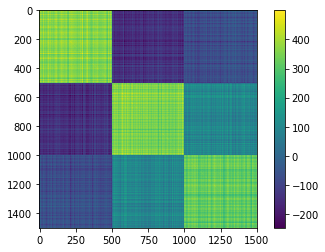

In [62]:
imshow(torch.mm(data, data.T))
colorbar()

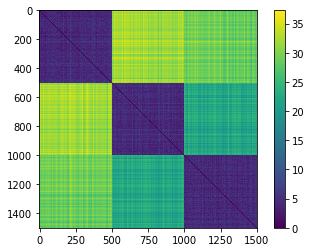

In [63]:
imshow(squareform(pdist(data)))
colorbar()

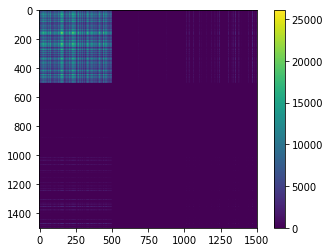

In [69]:
imshow(torch.mm(distance, distance.T))
colorbar()

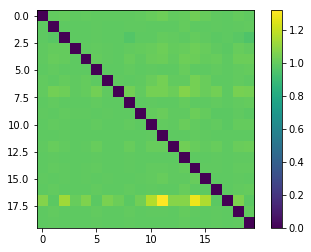

In [65]:
imshow(model.Wy)
colorbar()

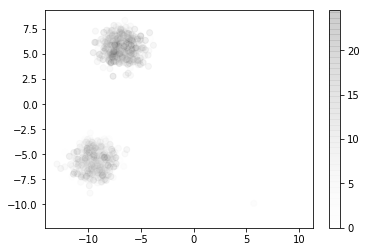

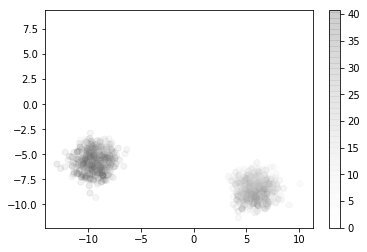

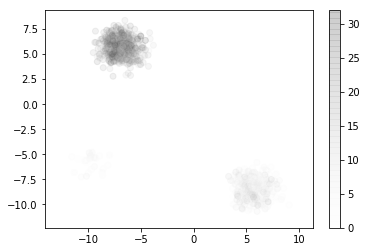

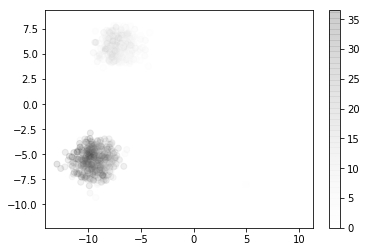

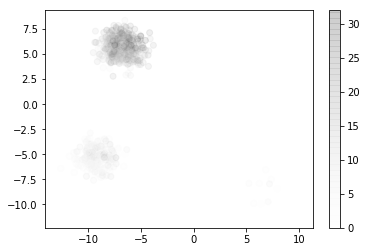

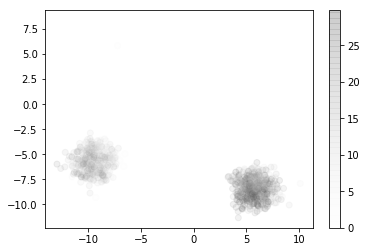

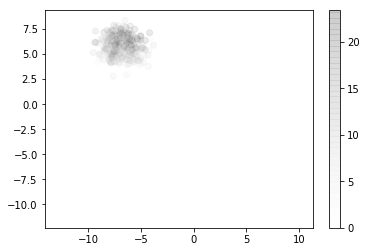

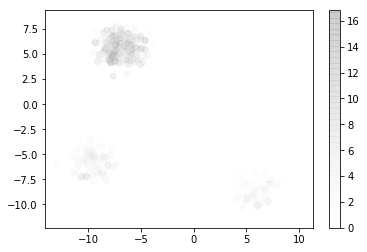

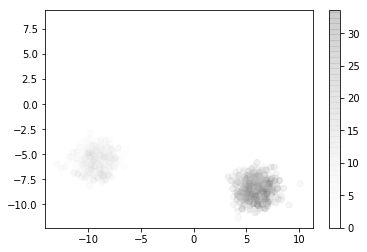

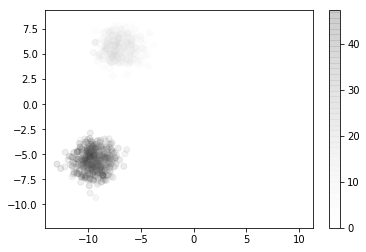

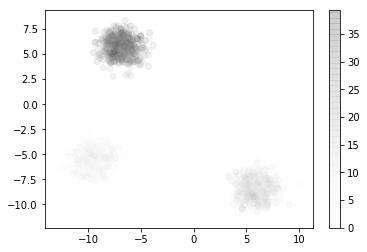

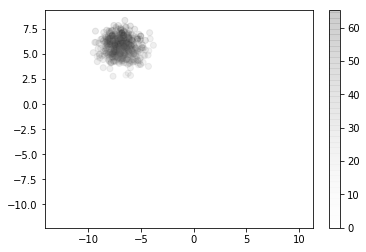

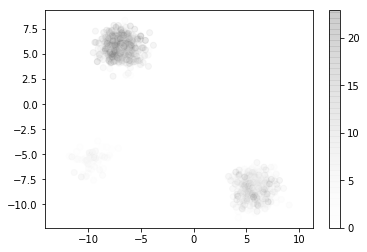

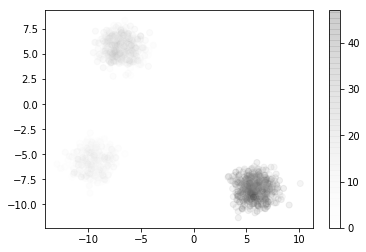

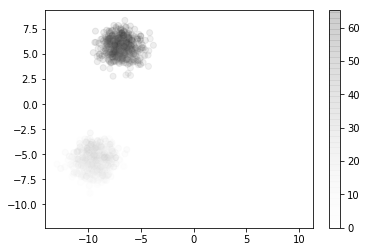

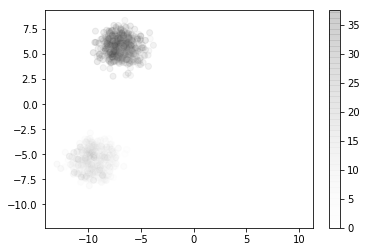

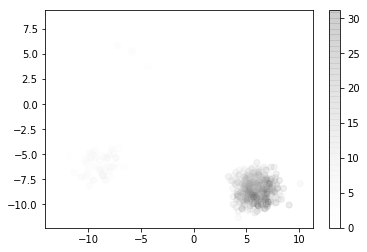

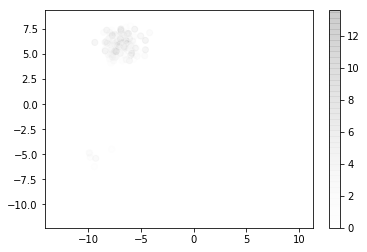

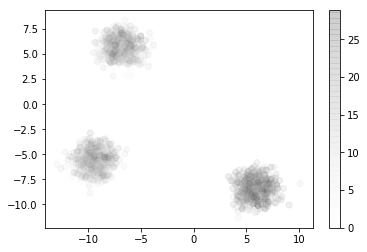

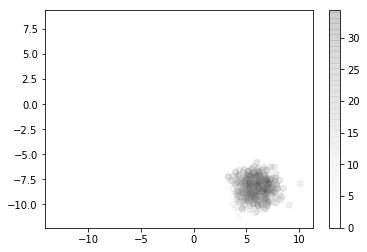

In [56]:
for i in range(20):
    plt.scatter(X[:,0], X[:,1], c=distance[:, i], cmap='Greys', alpha=0.1)
    colorbar()
    plt.show()

In [21]:
distance

tensor([106.7697,   4.1368,   0.0000])

## Evaluate

In [26]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor())).cuda()
evaluate_y = Variable(test_loader.dataset.test_labels).cuda()


output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu().float()
accuracy = d.sum()/d.size()[0]

print('Accuracy:', accuracy)

RuntimeError: matrices expected, got 3D, 2D tensors at C:\w\1\s\tmp_conda_3.7_055457\conda\conda-bld\pytorch_1565416617654\work\aten\src\TH/generic/THTensorMath.cpp:747

In [66]:
#output_compare
distance = torch.zeros(3)
correct_count = 0
for k in range(1500):
    i = k
    inputs = data[i]
    labels = categories[i]
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, Wx_learning_rate_1, Wy_learning_rate_1)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, Wx_learning_rate_2, Wy_learning_rate_2)
    outputs = model.forward(inputs.flatten().view(-1, 10).T)
    j = 0
    while(loss > 10**-5 and j < 10**5):
        outputs = model.forward(inputs.flatten().view(-1, 10).T)
        loss = criterion(outputs, model.Y0)
        model.updateY(outputs)
        j += 1
    outputs_2 = model_2.forward(outputs)
    j = 0
    while(loss_2 > 10**-5 and j < 10**5):
        outputs_2 = model_2.forward(outputs)
        loss_2 = criterion(outputs_2, model_2.Y0)
        model_2.updateY(outputs_2)
        j += 1
#    distance[i] = outputs.T
    for j in range(2):
        distance[j] = torch.nn.functional.mse_loss(outputs_2.T[0], output_compare[j])
#    print(outputs_2.T)
#    print(np.argmin(distance.data.numpy()), '   ', labels)
    if np.argmin(distance.data.numpy()) == labels:
        correct_count += 1
print(float(correct_count)/1000)

0.759
